 Preparation

In [1]:
# Import Libraries

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import time
from PIL import Image

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Reshape, concatenate, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 75

In [3]:
metadata = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
display(metadata)
metadata.info()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])

df = pd.DataFrame({
    "patient_id" : data_map[::2],
    "path" : data_map[1::2]
})

df

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
7853,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [5]:
df_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9

images = sorted(df_images["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

df_brain = pd.DataFrame({
    "patient_id": df_images.patient_id.values,
    "image_path": images,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    return 0

df_brain["diagnosis"] = df_brain["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

df_brain

,patient_id,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [8]:
# Create Figure
fig = go.Figure()

# Create Bar Chart
diagnosis_count = df_brain["diagnosis"].value_counts()
diagnosis_percentage = (diagnosis_count / diagnosis_count.sum()) * 100
fig.add_trace(
    go.Bar(
        x=[str(x) for x in diagnosis_count.index.tolist()],
        y=diagnosis_count.values,
        marker_color=["#309cd4", "#03020e"],
        text=[f"{percentage:.2f}%" for percentage in diagnosis_percentage],
        textfont_size=20,
        textfont_color="white"
    )
)

# Update Axes
fig.update_xaxes(showgrid=False, linecolor='black', title_text='Diagnosis')
fig.update_yaxes(showgrid=False, linecolor='black')

# Update Layout
fig.update_layout(title_text="Brain Tumor Distribution", title_x=0.5, font_family="Times New Roman",
                  width=600, height=400,
                  plot_bgcolor='White'
)

# Show
fig.show(iframe="connected")

In [9]:
df_patient_tumor = df_brain[df_brain["diagnosis"]==1].reset_index(drop=True)
df_patient_num_dns = df_patient_tumor.groupby("patient_id")["diagnosis"].sum().reset_index().sort_values(by="diagnosis", ascending=False).reset_index(drop=True)
patient_id = df_patient_num_dns[df_patient_num_dns["diagnosis"]==11]["patient_id"].iloc[0, ]
df_patient_one = df_brain[df_brain["patient_id"]==patient_id].reset_index(drop=True)
display(df_patient_one.head())
df_patient_one.shape

,patient_id,image_path,mask_path,diagnosis
0,TCGA_DU_8165_19970205,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1,TCGA_DU_8165_19970205,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_8165_19970205,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_8165_19970205,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_8165_19970205,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


(36, 4)

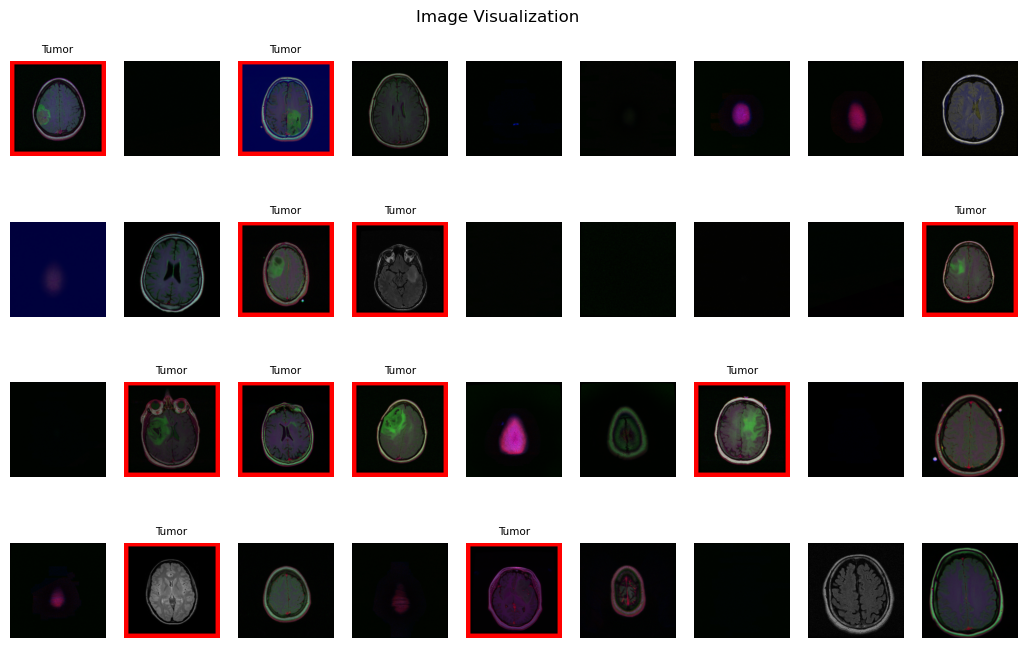

In [10]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = Image.new('RGB', (b+ny+b, b+nx+b), (255, 0, 0)) # RGB color tuple
    framed_img = np.array(framed_img.getdata()).reshape(framed_img.size[0], framed_img.size[1], 3)
    framed_img[b:-b, b:-b] = img
    return framed_img

fig, axs = plt.subplots(4, 9, figsize=(13, 8))

for i in range(df_patient_one.shape[0]):
    mri_sm = cv2.imread(df_patient_one["image_path"][i])
    if(df_patient_one["diagnosis"][i]==1): # Tumor
        axs[i//9, i%9].imshow(frame_image(mri_sm, 13))
        axs[i//9, i%9].set_title("Tumor", fontsize=7.5)
    else: # No Tumor
        axs[i//9, i%9].imshow(mri_sm)
        
    axs[i//9, i%9].axis("off")

# Title
plt.suptitle("Image Visualization", x=0.5, y=0.92)

# Show
plt.show()

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">2.3. Data Preprocessing
    </h2>
</div>

In [11]:
df_brain_train = df_brain.drop(columns=['patient_id'])
df_brain_train, df_brain_test = train_test_split(df_brain_train, test_size=0.1, random_state=2023)

In [12]:
def get_data(img_path, mask_path):
    X_train = []
    Y_train = []

    for i in range(len(img_path)):
        img = cv2.imread(img_path[i])
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(mask_path[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.

        X_train.append(img)
        Y_train.append(mask)

    return np.array(X_train), np.array(Y_train)

# Training Dataset
train_img_path = list(df_brain_train["image_path"])
train_mask_path = list(df_brain_train["mask_path"])

X_train, Y_train = get_data(train_img_path, train_mask_path)

# Testing Dataset
test_img_path = list(df_brain_test["image_path"])
test_mask_path = list(df_brain_test["mask_path"])

X_test, Y_test = get_data(test_img_path, test_mask_path)

 Image Segmentation 🍁

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.1. Helper Function
    </h2>
</div>

In [13]:
# Loss and Metrics
def bce_loss(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    y_true_f = tf.keras.backend.cast(y_true_f, 'float32')
    y_pred_f = tf.keras.backend.cast(y_pred_f, 'float32')
    
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.)
    return dice_coef_v

def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v

def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

bce_dice_loss(tf.constant([1., 1., 0.9]), 
              tf.constant([1., 1., 1.]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.52560085>

In [14]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=15
)

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.2. U-Net
    </h2>
</div>

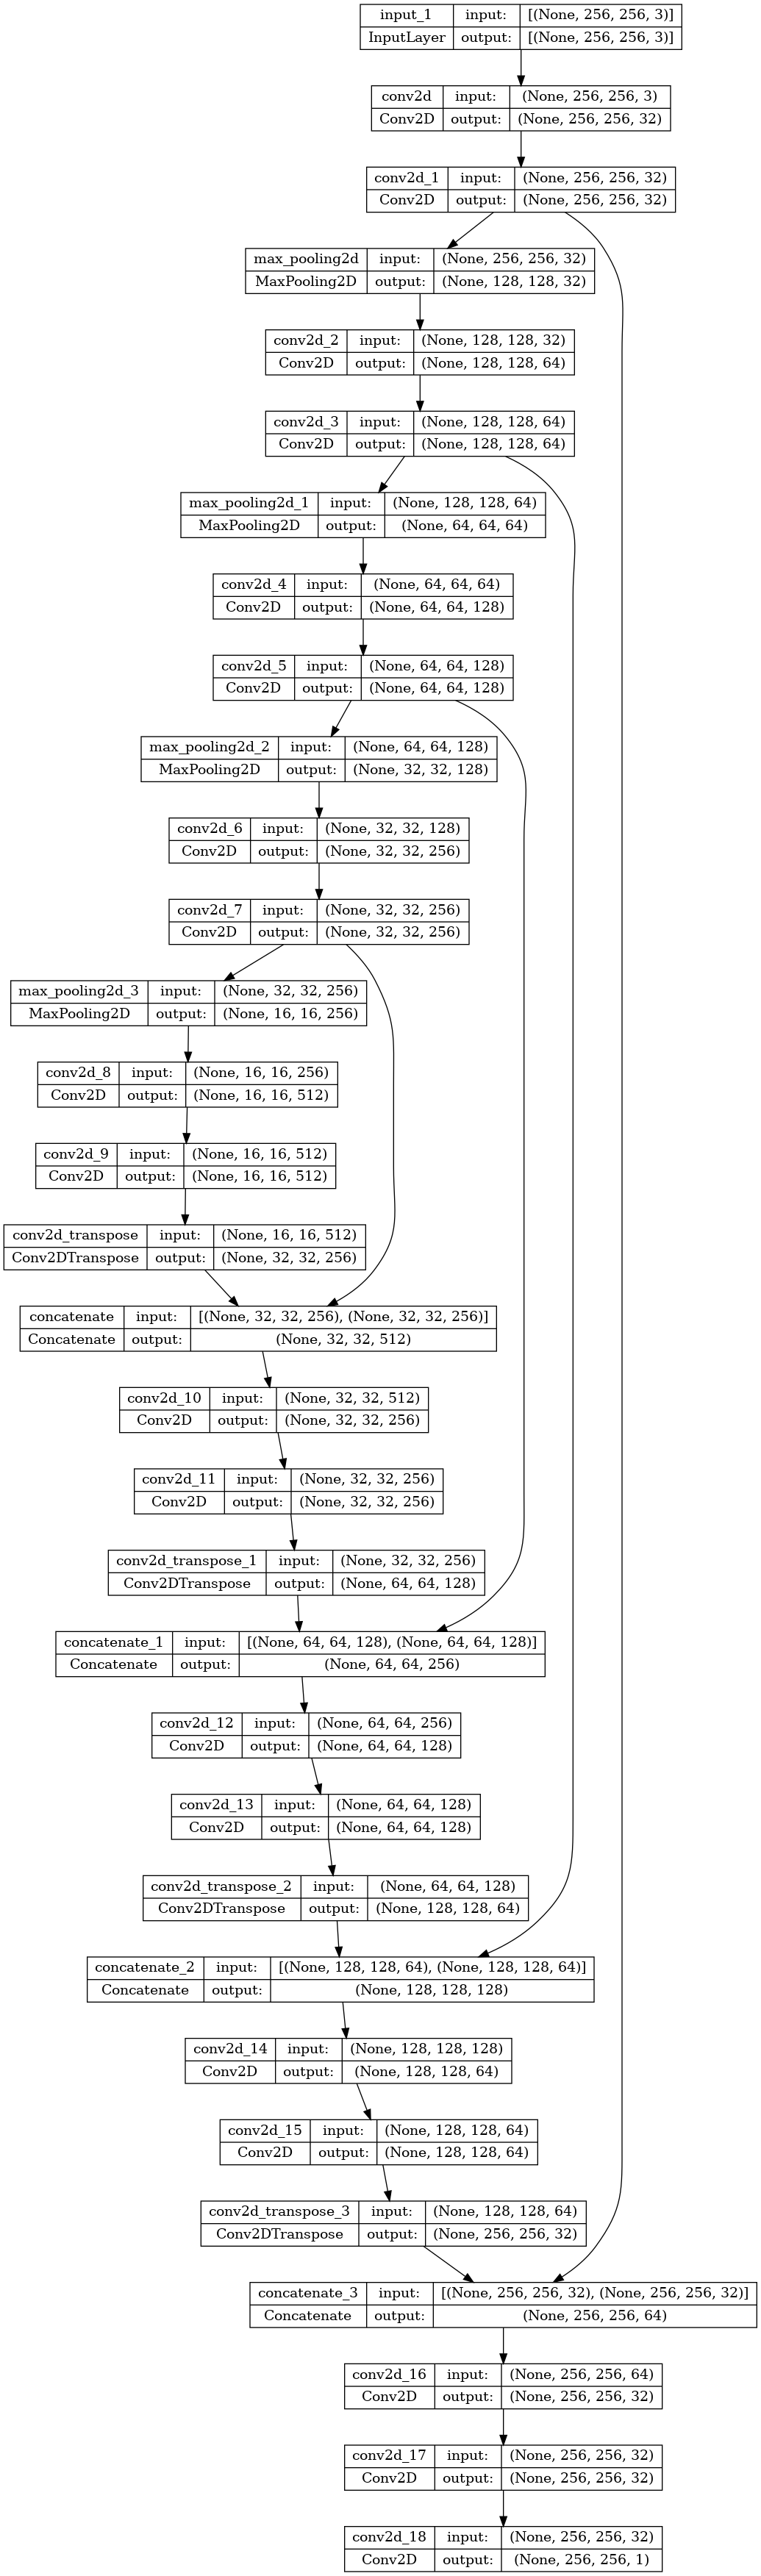

In [15]:
def build_unet_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    display(tf.keras.utils.plot_model(model, to_file='unet.png', show_shapes=True))
    
    return model

unet_model = build_unet_model()

In [16]:
# Model Compiling
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_unet_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
unet_history = unet_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
unet_time = end_time-start_time

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 0.8310 - dice_coef: 0.3213
Epoch 1: val_loss improved from inf to 0.88901, saving model to best_unet_model.h5
197/197 [==============================] - 46s 156ms/step - loss: 0.8310 - dice_coef: 0.3213 - val_loss: 0.8890 - val_dice_coef: 0.2808
Epoch 2/75
197/197 [==============================] - ETA: 0s - loss: 0.6472 - dice_coef: 0.4334
Epoch 2: val_loss improved from 0.88901 to 0.56410, saving model to best_unet_model.h5
197/197 [==============================] - 27s 138ms/step - loss: 0.6472 - dice_coef: 0.4334 - val_loss: 0.5641 - val_dice_coef: 0.4945
Epoch 3/75
197/197 [==============================] - ETA: 0s - loss: 0.5446 - dice_coef: 0.5062
Epoch 3: val_loss improved from 0.56410 to 0.49646, saving model to best_unet_model.h5
197/197 [==============================] - 27s 136ms/step - loss: 0.5446 - dice_coef: 0.5062 - val_loss: 0.4965 - val_dice_coef: 0.5458
Epoch 4/75
197/197 [========================

In [17]:
# Evaluation
unet_scores = unet_model.evaluate(
    X_test, 
    Y_test, 
    batch_size=1,
    verbose=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", unet_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", unet_scores[1]))

del unet_model
gc.collect()

393/393 [==============================] - 3s 6ms/step - loss: 0.7181 - dice_coef: 0.3229
Evaluate Test BCE Loss: 0.7181
Evaluate Test Dice Coefficient: 0.3229


8738

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.3. DeepLab V1
    </h2>
</div>

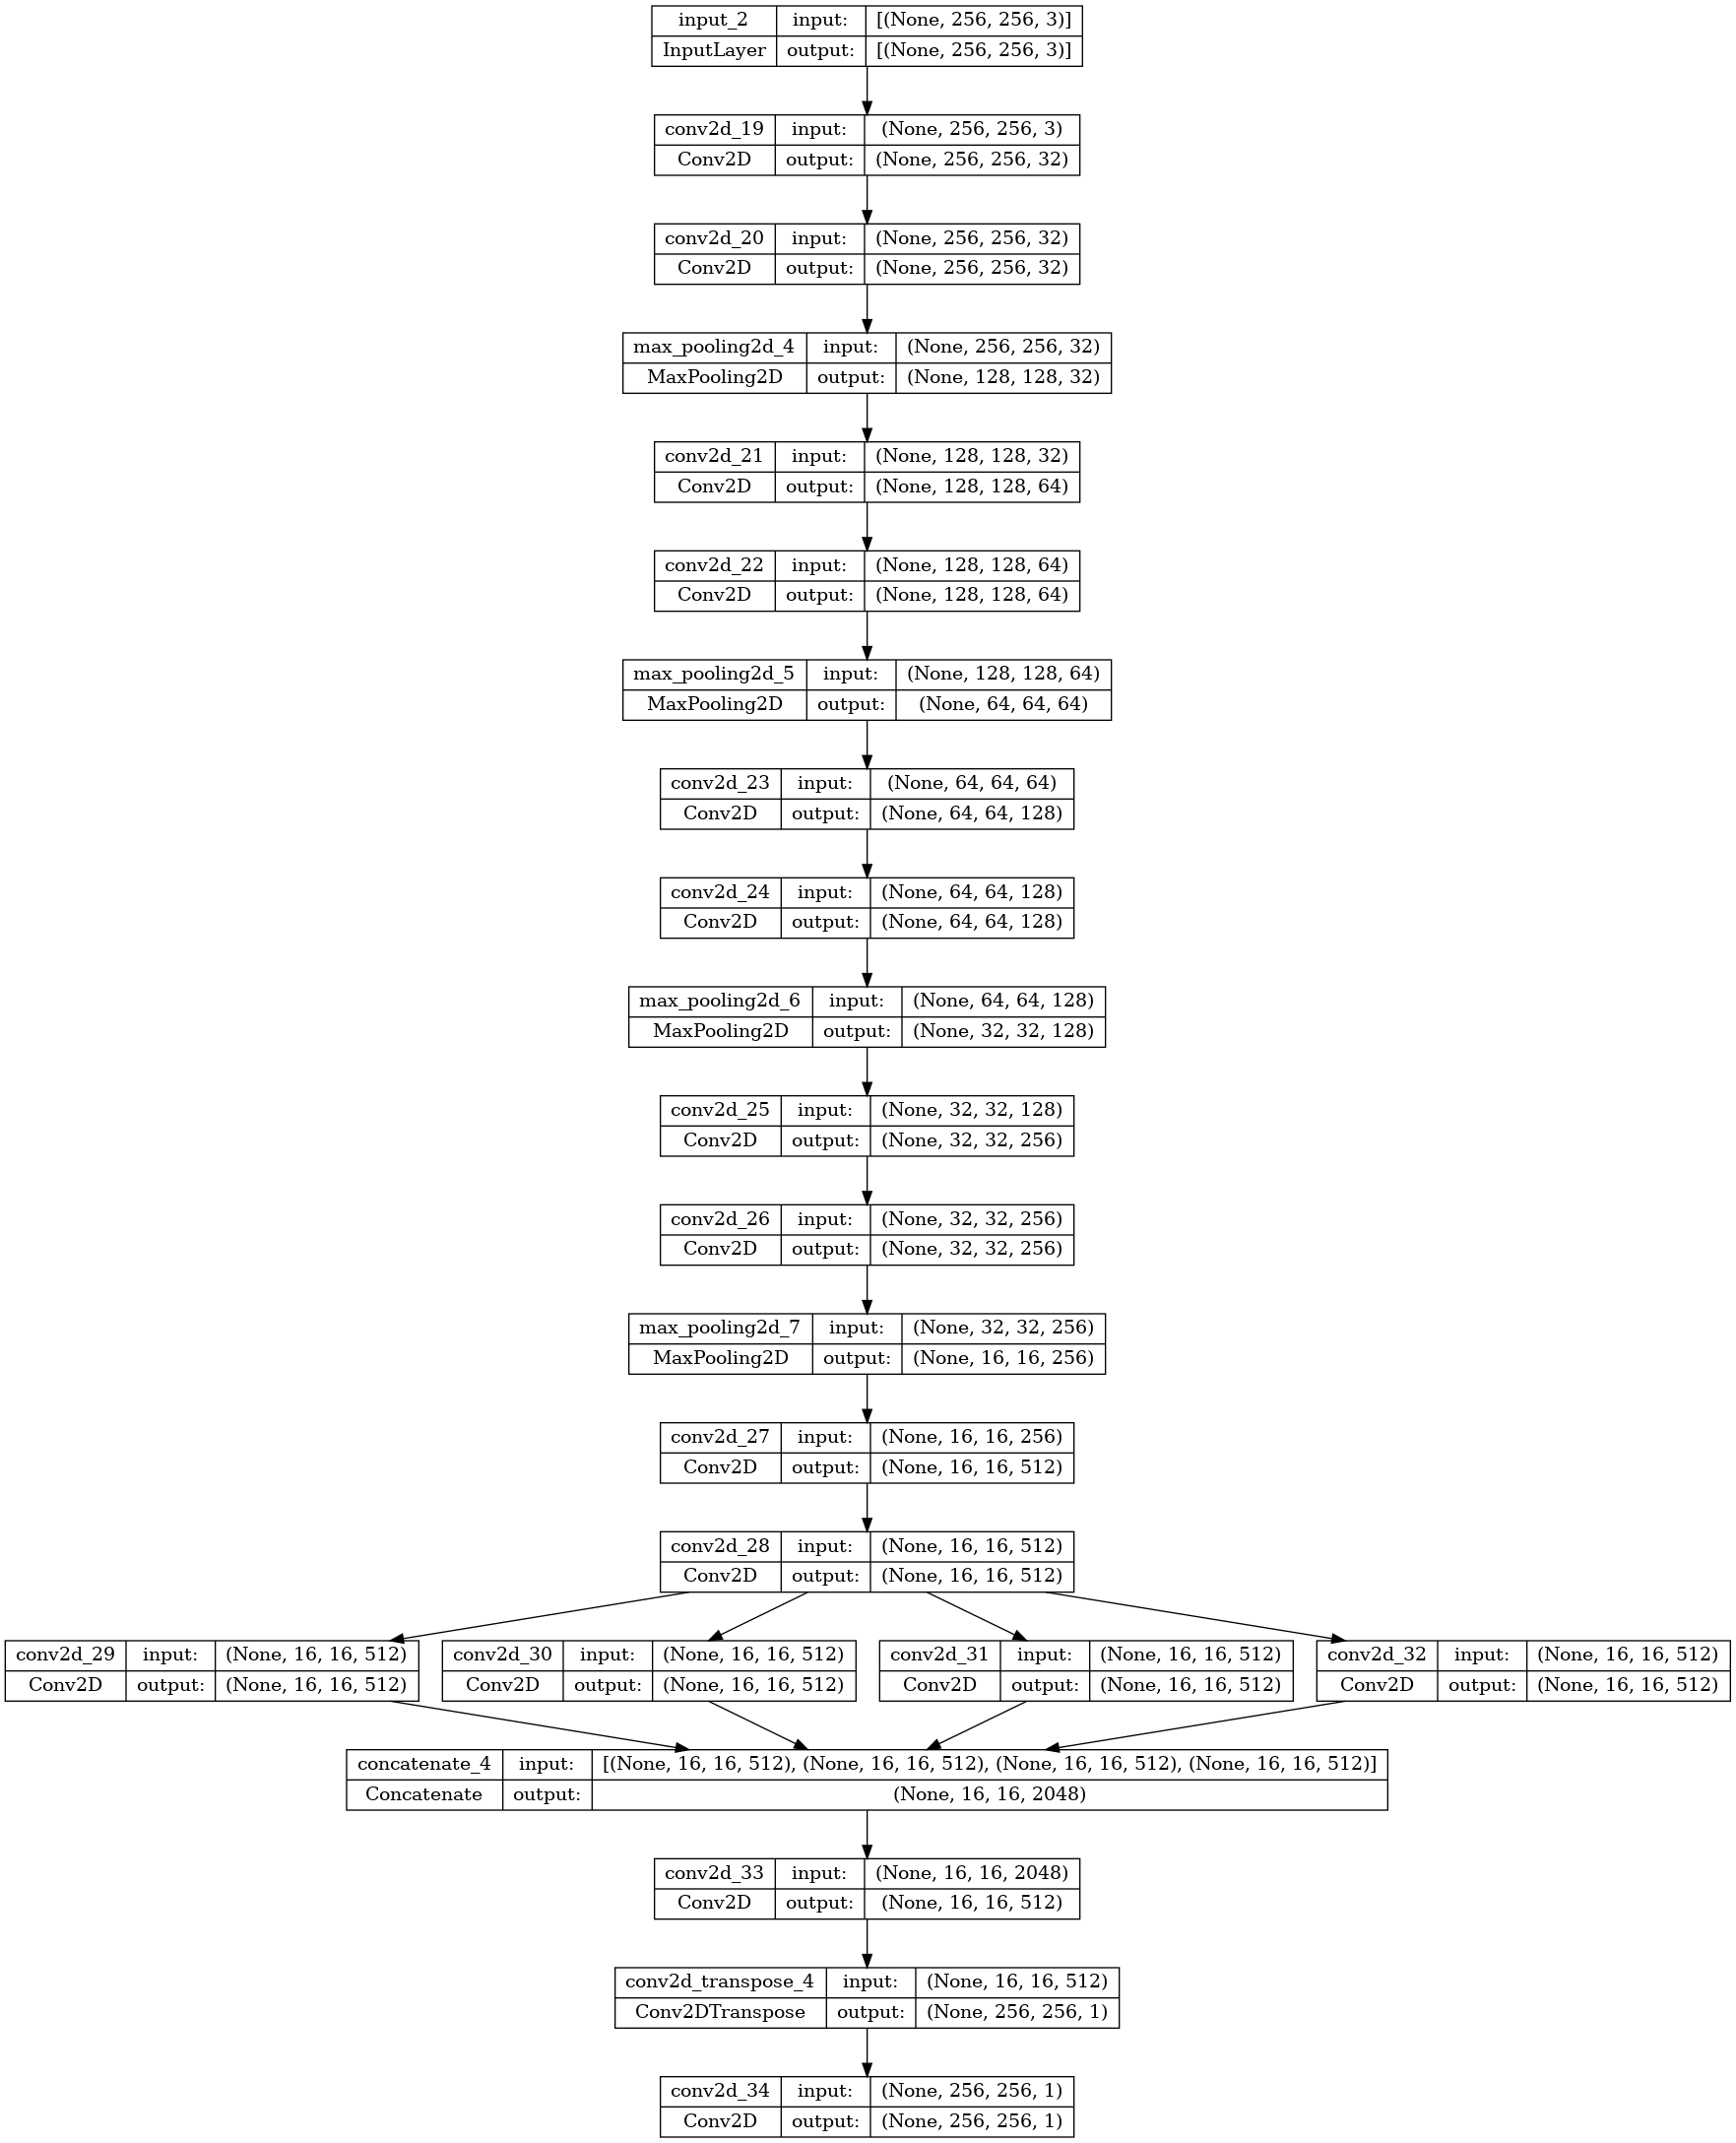

In [18]:
def build_deeplabv1_model():
    atrous_rates = [6, 12, 18, 24]
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Atrous (dilated) Convolutions with Different Rates
    atrous_layers = []
    for rate in atrous_rates:
        atrous_layer = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=rate)(conv5)
        atrous_layers.append(atrous_layer)
        
    # Concatenated Atrous Layers
    concat = Concatenate(axis=-1)(atrous_layers)
    
    # Decoder
    conv6 = Conv2D(512, 1, activation='relu', padding='same')(concat)

    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(conv6)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv1.png', show_shapes=True))
    
    return model

deeplabv1_model = build_deeplabv1_model()

In [19]:
# Model Compiling
deeplabv1_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_deeplabv1_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
deeplabv1_history = deeplabv1_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
deeplabv1_time = end_time-start_time

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 0.8503 - dice_coef: 0.2411
Epoch 1: val_loss improved from inf to 0.66678, saving model to best_deeplabv1_model.h5
197/197 [==============================] - 51s 213ms/step - loss: 0.8503 - dice_coef: 0.2411 - val_loss: 0.6668 - val_dice_coef: 0.3987
Epoch 2/75
197/197 [==============================] - ETA: 0s - loss: 0.5459 - dice_coef: 0.5116
Epoch 2: val_loss improved from 0.66678 to 0.47149, saving model to best_deeplabv1_model.h5
197/197 [==============================] - 38s 195ms/step - loss: 0.5459 - dice_coef: 0.5116 - val_loss: 0.4715 - val_dice_coef: 0.5714
Epoch 3/75
197/197 [==============================] - ETA: 0s - loss: 0.4437 - dice_coef: 0.6031
Epoch 3: val_loss improved from 0.47149 to 0.38361, saving model to best_deeplabv1_model.h5
197/197 [==============================] - 39s 196ms/step - loss: 0.4437 - dice_coef: 0.6031 - val_loss: 0.3836 - val_dice_coef: 0.6620
Epoch 4/75
197/197 [=========

In [20]:
# Evaluation
deeplabv1_scores = deeplabv1_model.evaluate(
    X_test, 
    Y_test, 
    verbose=1,
    batch_size=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", deeplabv1_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", deeplabv1_scores[1]))

del deeplabv1_model
gc.collect()

393/393 [==============================] - 4s 8ms/step - loss: 0.2228 - dice_coef: 0.8048
Evaluate Test BCE Loss: 0.2228
Evaluate Test Dice Coefficient: 0.8048


3305

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.4. DeepLab V2
    </h2>
</div>

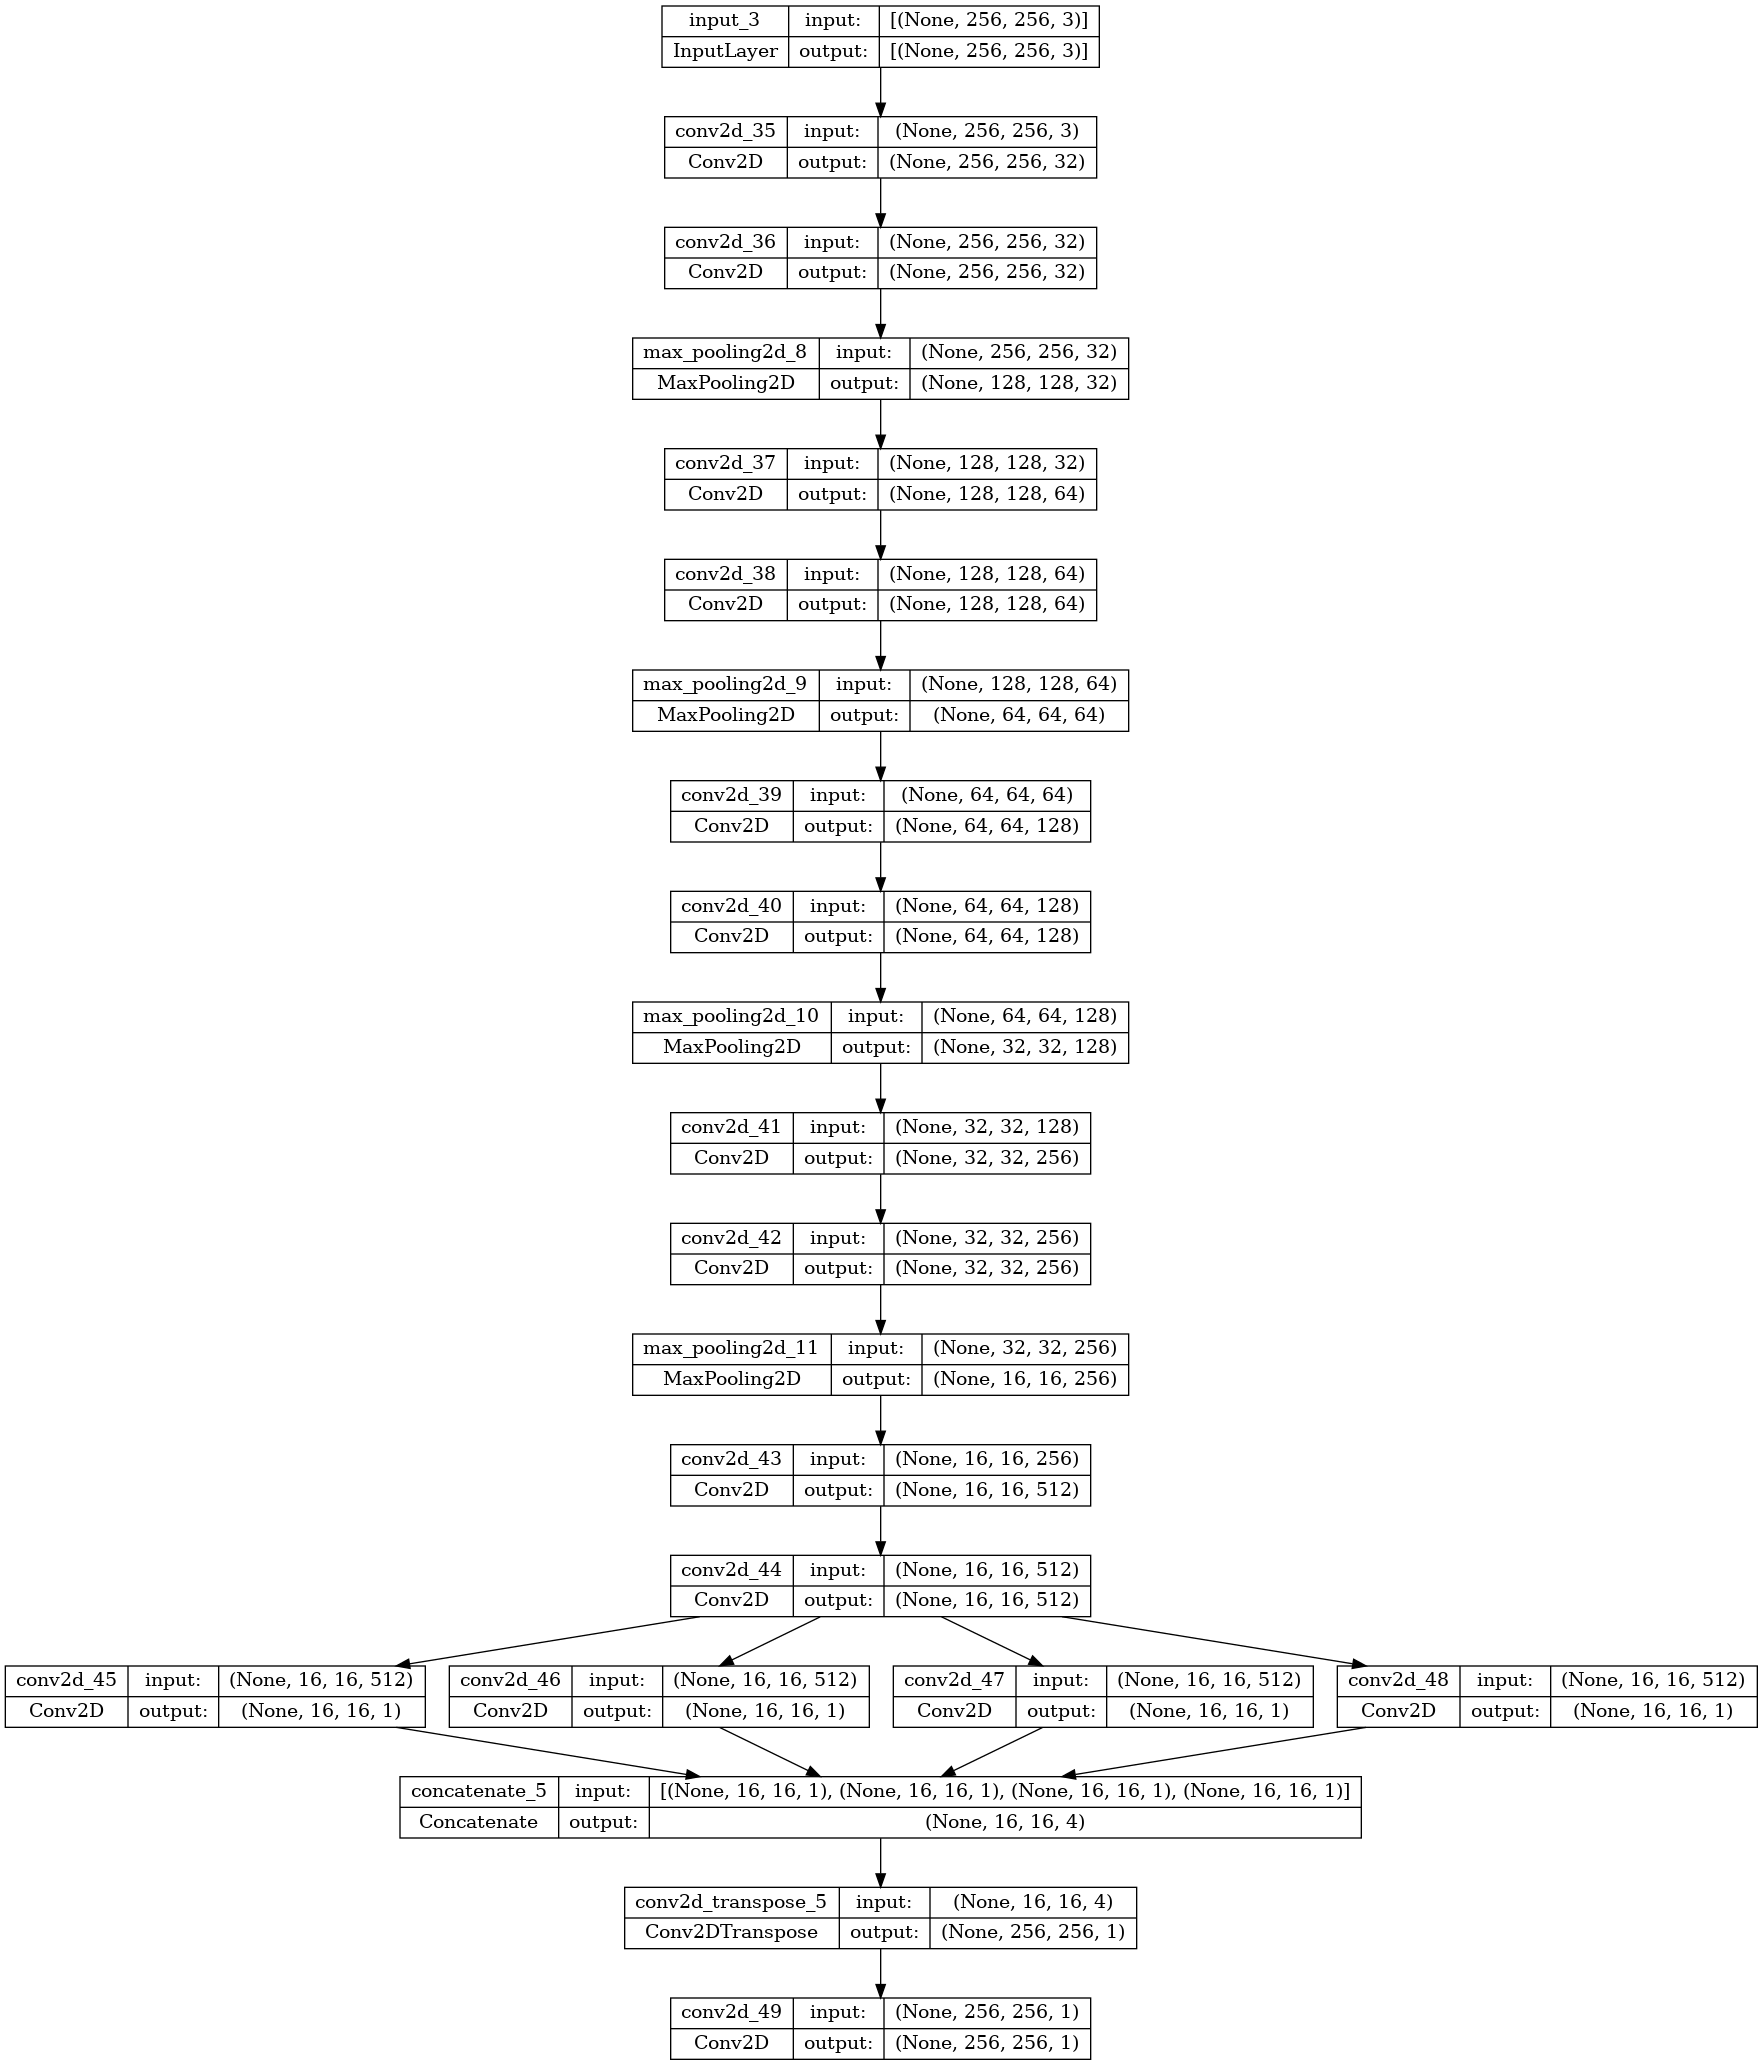

In [21]:
def aspp_v2(inputs, atrous_rates):
    aspp_layers = []
    for rate in atrous_rates:
        aspp_layer = Conv2D(1, 3, activation='relu', padding='same', dilation_rate=rate)(inputs)
        aspp_layers.append(aspp_layer)
    concat = Concatenate(axis=-1)(aspp_layers)
    return concat

def build_deeplabv2_model():
    atrous_rates = [6, 12, 18, 24]
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp_output = aspp_v2(conv5, atrous_rates)

    # Decoder
    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(aspp_output)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=inputs, outputs=outputs)
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv2.png', show_shapes=True))
    
    return model

deeplabv2_model = build_deeplabv2_model()

In [22]:
# Model Compiling
deeplabv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_deeplabv2_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
deeplabv2_history = deeplabv2_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
deeplabv2_time = end_time-start_time

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 1.0554 - dice_coef: 0.0999
Epoch 1: val_loss improved from inf to 0.96327, saving model to best_deeplabv2_model.h5
197/197 [==============================] - 23s 90ms/step - loss: 1.0554 - dice_coef: 0.0999 - val_loss: 0.9633 - val_dice_coef: 0.1154
Epoch 2/75
196/197 [============================>.] - ETA: 0s - loss: 0.9053 - dice_coef: 0.1515
Epoch 2: val_loss improved from 0.96327 to 0.88761, saving model to best_deeplabv2_model.h5
197/197 [==============================] - 16s 82ms/step - loss: 0.9056 - dice_coef: 0.1508 - val_loss: 0.8876 - val_dice_coef: 0.1614
Epoch 3/75
196/197 [============================>.] - ETA: 0s - loss: 0.8351 - dice_coef: 0.2234
Epoch 3: val_loss improved from 0.88761 to 0.81861, saving model to best_deeplabv2_model.h5
197/197 [==============================] - 16s 83ms/step - loss: 0.8349 - dice_coef: 0.2240 - val_loss: 0.8186 - val_dice_coef: 0.2866
Epoch 4/75
196/197 [============

In [23]:
# Evaluation
deeplabv2_scores = deeplabv2_model.evaluate(
    X_test, 
    Y_test, 
    verbose=1,
    batch_size=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", deeplabv2_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", deeplabv2_scores[1]))

del deeplabv2_model
gc.collect()

393/393 [==============================] - 2s 6ms/step - loss: 0.1698 - dice_coef: 0.8542
Evaluate Test BCE Loss: 0.1698
Evaluate Test Dice Coefficient: 0.8542


4214

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.5. DeepLab V3
    </h2>
</div>

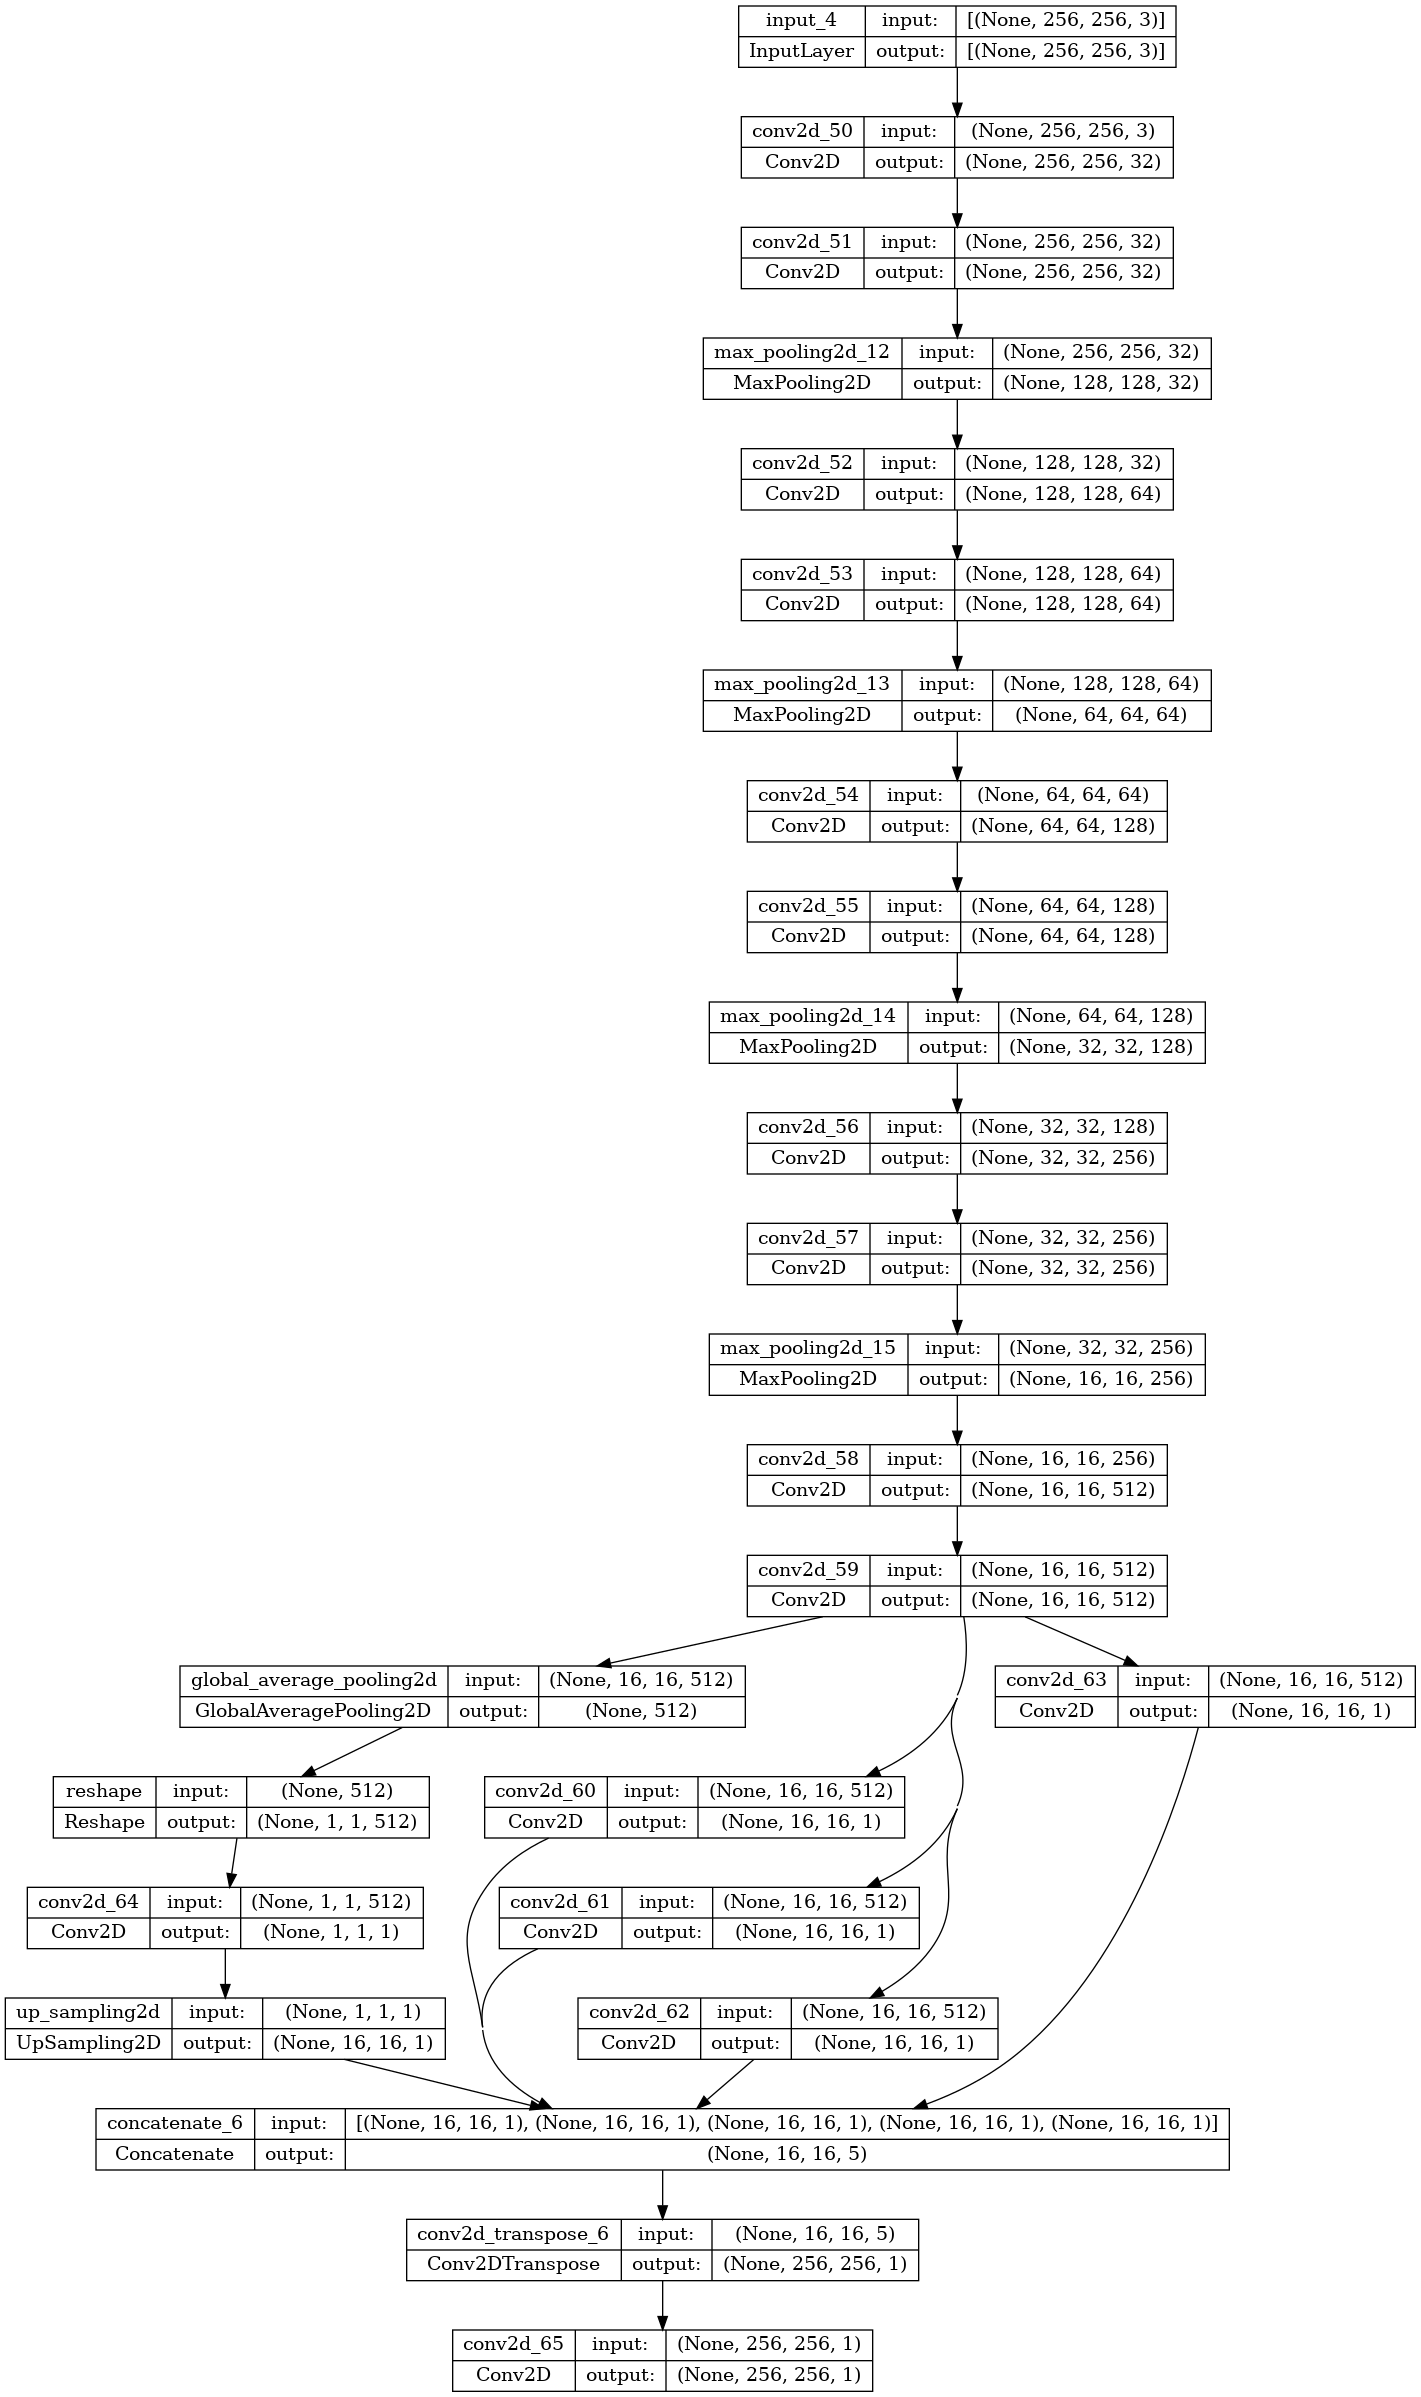

In [24]:
def aspp_v3(inputs, atrous_rates):
    aspp_layers = []
    for rate in atrous_rates:
        aspp_layer = Conv2D(1, 3, activation='relu', padding='same', dilation_rate=rate)(inputs)
        aspp_layers.append(aspp_layer)

    # Add Image-Level features
    img_level = GlobalAveragePooling2D()(inputs)
    img_level = Reshape((1, 1, -1))(img_level)
    img_level = Conv2D(1, 1, activation='relu', padding='same')(img_level)
    img_level = UpSampling2D(size=tf.keras.backend.int_shape(inputs)[1:3], interpolation='bilinear')(img_level)
    
    aspp_layers.append(img_level)
    concat = Concatenate(axis=-1)(aspp_layers)
    return concat

def build_deeplabv3_model():
    atrous_rates = [6, 12, 18, 24]
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp_output = aspp_v3(conv5, atrous_rates)

    # Decoder
    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(aspp_output)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=inputs, outputs=outputs)
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv3.png', show_shapes=True))
    
    return model

deeplabv3_model = build_deeplabv3_model()

In [25]:
# Model Compiling
deeplabv3_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_deeplabv3_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
deeplabv3_history = deeplabv3_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
deeplabv3_time = end_time-start_time

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 1.0842 - dice_coef: 0.0903
Epoch 1: val_loss improved from inf to 0.89782, saving model to best_deeplabv3_model.h5
197/197 [==============================] - 22s 86ms/step - loss: 1.0842 - dice_coef: 0.0903 - val_loss: 0.8978 - val_dice_coef: 0.1537
Epoch 2/75
196/197 [============================>.] - ETA: 0s - loss: 0.8927 - dice_coef: 0.1616
Epoch 2: val_loss improved from 0.89782 to 0.88638, saving model to best_deeplabv3_model.h5
197/197 [==============================] - 16s 82ms/step - loss: 0.8928 - dice_coef: 0.1613 - val_loss: 0.8864 - val_dice_coef: 0.1663
Epoch 3/75
196/197 [============================>.] - ETA: 0s - loss: 0.8813 - dice_coef: 0.1711
Epoch 3: val_loss improved from 0.88638 to 0.88027, saving model to best_deeplabv3_model.h5
197/197 [==============================] - 16s 82ms/step - loss: 0.8816 - dice_coef: 0.1702 - val_loss: 0.8803 - val_dice_coef: 0.1761
Epoch 4/75
196/197 [============

In [26]:
# Evaluation
deeplabv3_scores = deeplabv3_model.evaluate(
    X_test, 
    Y_test, 
    verbose=1,
    batch_size=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", deeplabv3_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", deeplabv3_scores[1]))

del deeplabv3_model
gc.collect()

393/393 [==============================] - 2s 6ms/step - loss: 0.1628 - dice_coef: 0.8833
Evaluate Test BCE Loss: 0.1628
Evaluate Test Dice Coefficient: 0.8833


7659

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.6. DeepLab V3+
    </h2>
</div>

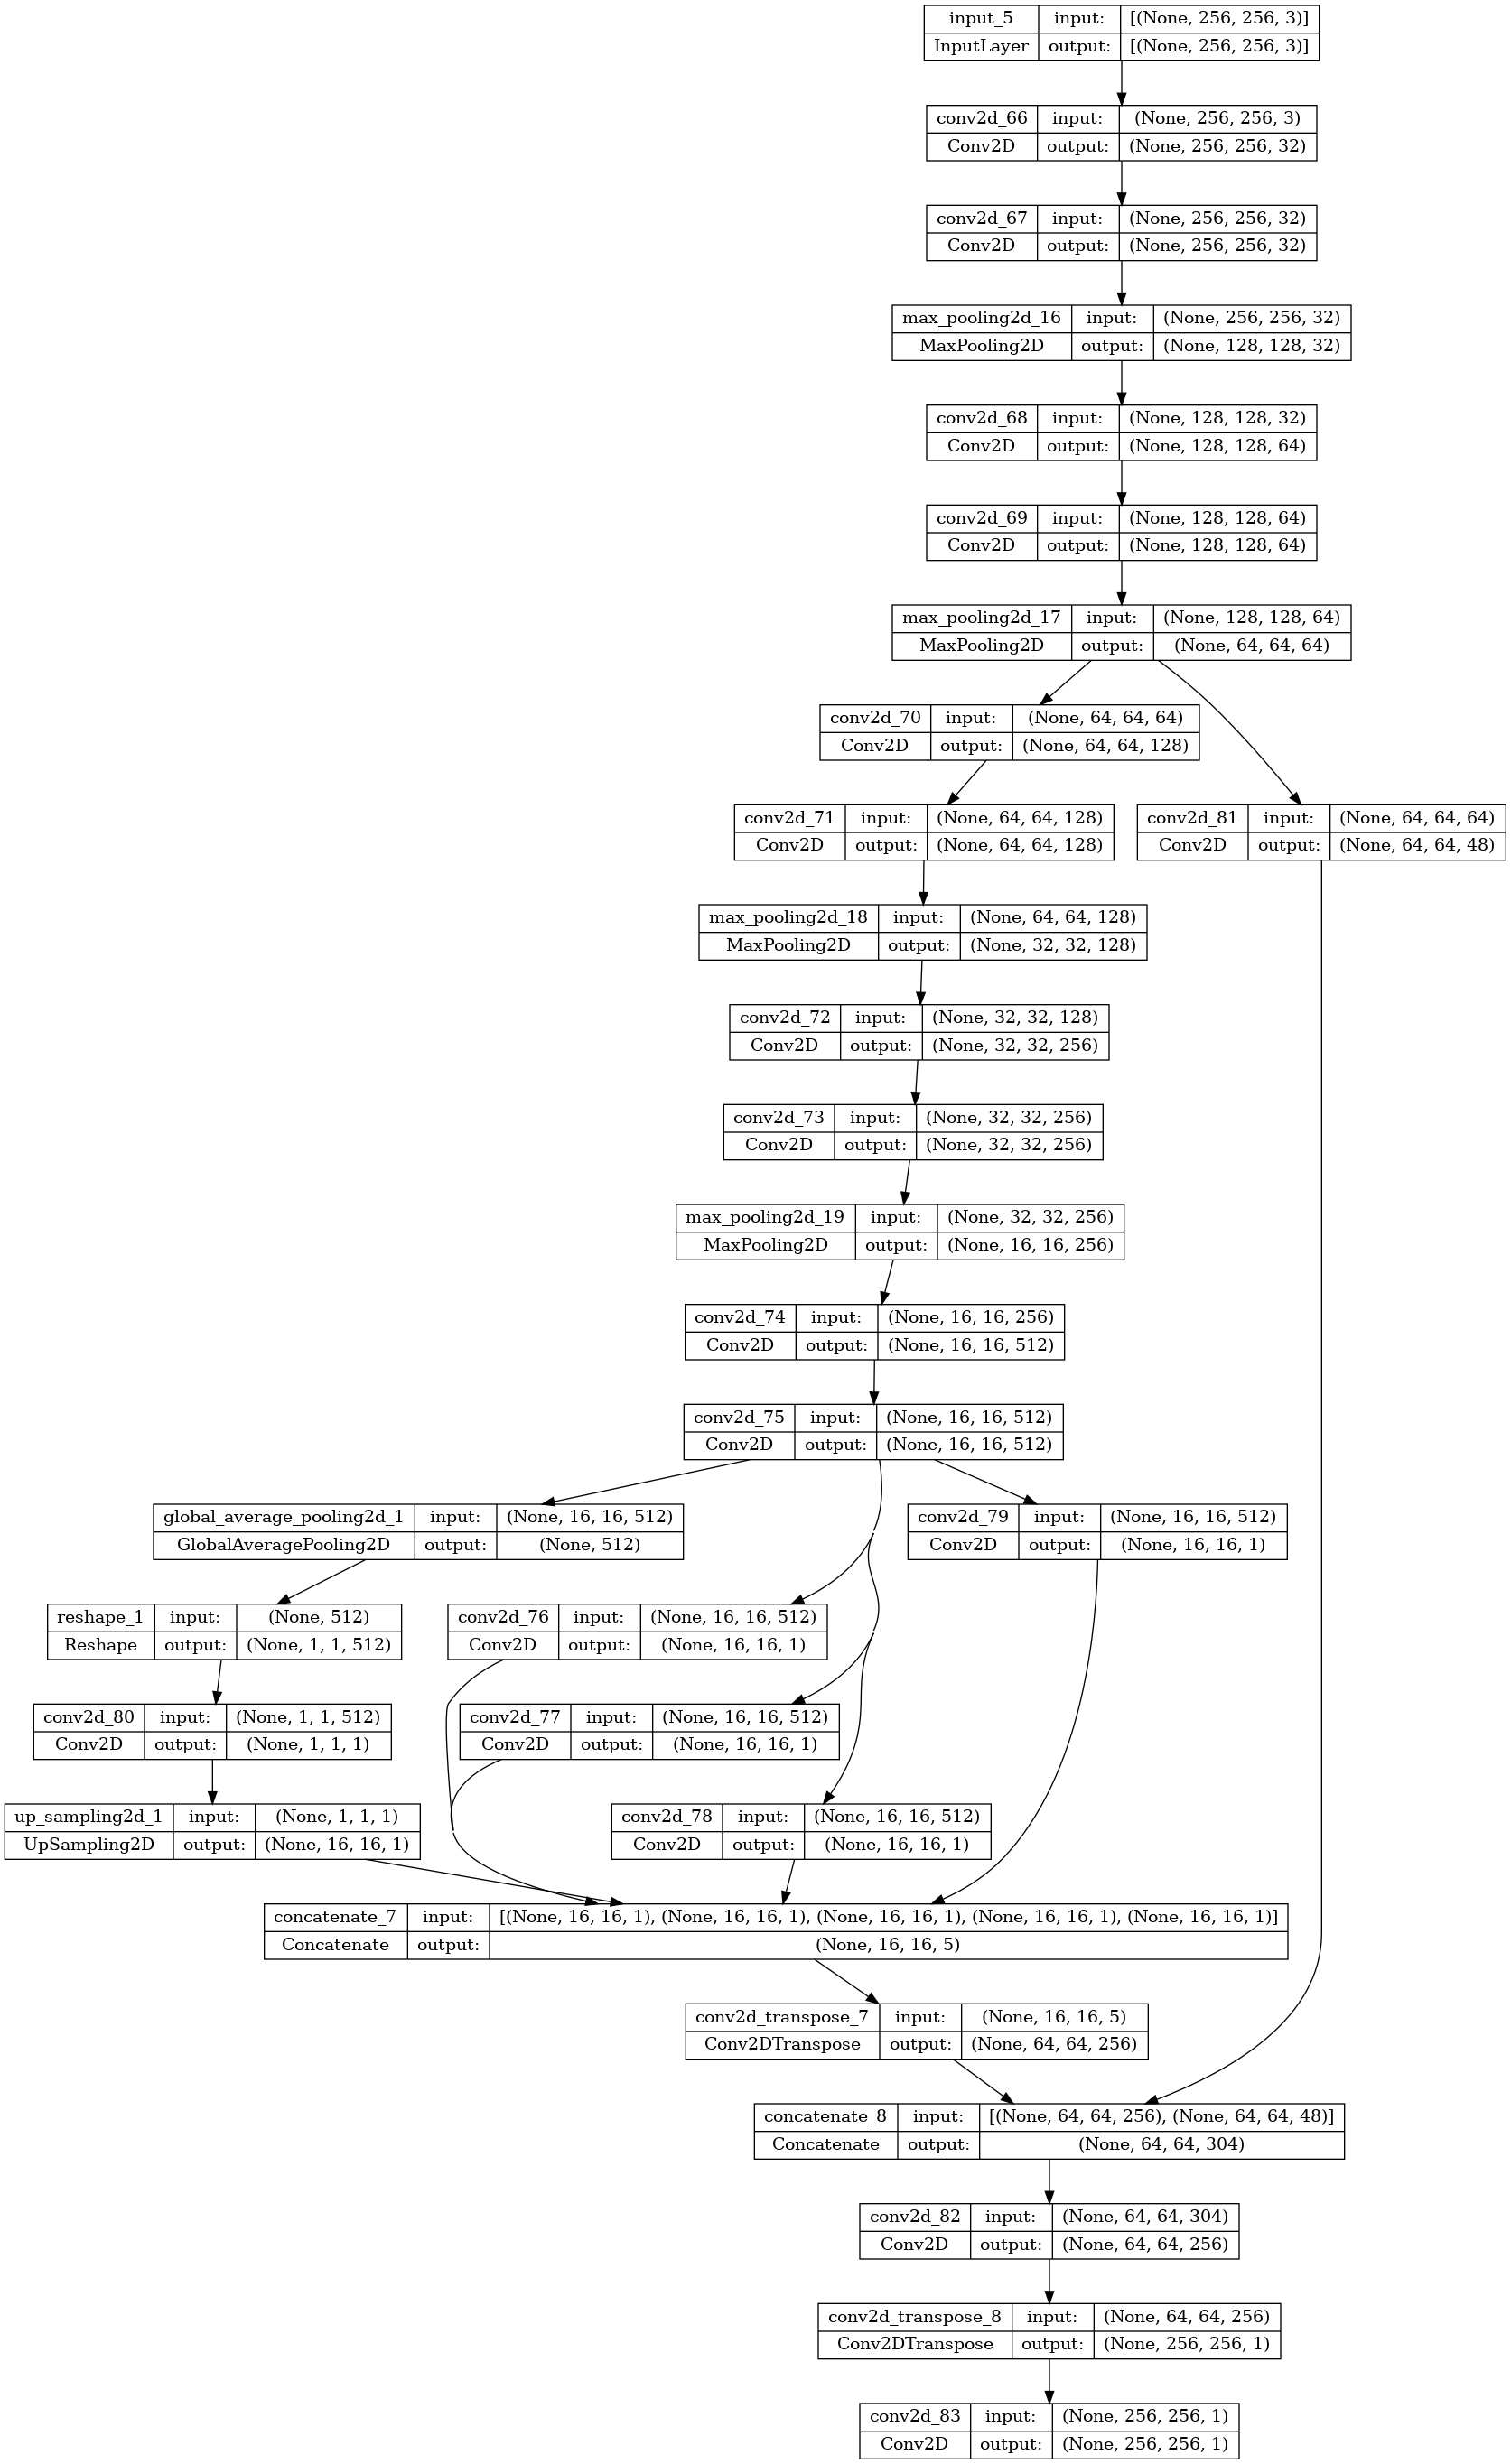

In [27]:
def aspp_v3(inputs, atrous_rates):
    aspp_layers = []
    for rate in atrous_rates:
        aspp_layer = Conv2D(1, 3, activation='relu', padding='same', dilation_rate=rate)(inputs)
        aspp_layers.append(aspp_layer)

    # Add Image-Level features
    img_level = GlobalAveragePooling2D()(inputs)
    img_level = Reshape((1, 1, -1))(img_level)
    img_level = Conv2D(1, 1, activation='relu', padding='same')(img_level)
    img_level = UpSampling2D(size=tf.keras.backend.int_shape(inputs)[1:3], interpolation='bilinear')(img_level)
    
    aspp_layers.append(img_level)
    concat = Concatenate(axis=-1)(aspp_layers)
    return concat

def build_deeplabv3_plus_model():
    atrous_rates = [6, 12, 18, 24]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp_output = aspp_v3(conv5, atrous_rates)

    # Decoder
    upsample_aspp = Conv2DTranspose(256, kernel_size=4, strides=4, padding='same', activation='relu')(aspp_output)
    low_level_features = Conv2D(48, 1, activation='relu', padding='same')(pool2)
    concat = Concatenate(axis=-1)([upsample_aspp, low_level_features])
    decoder_conv = Conv2D(256, 3, activation='relu', padding='same')(concat)
    upsample = Conv2DTranspose(1, kernel_size=16, strides=4, padding='same')(decoder_conv)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=inputs, outputs=outputs)
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv3_plus.png', show_shapes=True))
    
    return model

deeplabv3_plus_model = build_deeplabv3_plus_model()

In [28]:
# Model Compiling
deeplabv3_plus_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_deeplabv3_plus_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
deeplabv3_plus_history = deeplabv3_plus_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
deeplabv3_plus_time = end_time-start_time

Epoch 1/75
197/197 [==============================] - ETA: 0s - loss: 0.7370 - dice_coef: 0.3530
Epoch 1: val_loss improved from inf to 0.57892, saving model to best_deeplabv3_plus_model.h5
197/197 [==============================] - 29s 112ms/step - loss: 0.7370 - dice_coef: 0.3530 - val_loss: 0.5789 - val_dice_coef: 0.4583
Epoch 2/75
197/197 [==============================] - ETA: 0s - loss: 0.5605 - dice_coef: 0.4939
Epoch 2: val_loss did not improve from 0.57892
197/197 [==============================] - 20s 104ms/step - loss: 0.5605 - dice_coef: 0.4939 - val_loss: 0.5973 - val_dice_coef: 0.4826
Epoch 3/75
197/197 [==============================] - ETA: 0s - loss: 0.5255 - dice_coef: 0.5241
Epoch 3: val_loss improved from 0.57892 to 0.54911, saving model to best_deeplabv3_plus_model.h5
197/197 [==============================] - 21s 105ms/step - loss: 0.5255 - dice_coef: 0.5241 - val_loss: 0.5491 - val_dice_coef: 0.4962
Epoch 4/75
197/197 [==============================] - ETA: 0s - 

In [29]:
# Evaluation
deeplabv3_plus_scores = deeplabv3_plus_model.evaluate(
    X_test, 
    Y_test, 
    verbose=1,
    batch_size=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", deeplabv3_plus_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", deeplabv3_plus_scores[1]))

del deeplabv3_plus_model
gc.collect()

393/393 [==============================] - 3s 6ms/step - loss: 0.5729 - dice_coef: 0.4637
Evaluate Test BCE Loss: 0.5729
Evaluate Test Dice Coefficient: 0.4637


11864

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #335981;">
    <h1 id = "results"
        style = "padding: 15px; 
                 color: White;
                 font-size: 26px;
                 font-family: Times New Roman;
                 font-weight: bold;">4. | Results 🌂
        <a class="anchor-link" id="results" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#results">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.1. Training Loss and Metrics
    </h2>
</div>

In [30]:
all_history = [unet_history, deeplabv1_history, deeplabv2_history, deeplabv3_history, deeplabv3_plus_history]
all_title = ["U-Net", "DeepLab V1", "DeepLab V2", "DeepLab V3", "DeepLab V3+"]

subplot_titles = []
for i in range(len(all_title)):
    subplot_titles.append(all_title[i] + " BCE+Dice Loss")
    subplot_titles.append(all_title[i] + " Dice Coefficient")

# Create Subplot
fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=subplot_titles,
    vertical_spacing=0.05
)

for i in range(len(all_history)):
    # Loss Plot
    loss = all_history[i].history['loss']
    val_loss = all_history[i].history['val_loss']
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(loss)+1), y=loss,
            mode="markers+lines",
            marker=dict(color="#309cd4", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#309cd4", width=2),
            name="Training Loss"
        ), row=i+1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(val_loss)+1), y=val_loss,
            mode="markers+lines",
            marker=dict(color="#335981", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#335981", width=2),
            name="Validation Loss"
        ), row=i+1, col=1
    )
    
    # Dice Coefficient Plot
    dice_coef = all_history[i].history['dice_coef']
    val_dice_coef = all_history[i].history['val_dice_coef']
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(dice_coef)+1), y=dice_coef,
            mode="markers+lines",
            marker=dict(color="#309cd4", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#309cd4", width=2),
            name="Training Dice Coefficient"
        ), row=i+1, col=2
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(val_dice_coef)+1), y=val_dice_coef,
            mode="markers+lines",
            marker=dict(color="#335981", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#335981", width=2),
            name="Validation Dice Coefficient"
        ), row=i+1, col=2
    )
    
    # Update Axes
    fig.update_xaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_xaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=2)
    fig.update_yaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_yaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=2)
    
# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5, font_family="Times New Roman",
    width=950, height=1500,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.2. Training Time
    </h2>
</div>

In [31]:
all_times = [unet_time, deeplabv1_time, deeplabv2_time, deeplabv3_time, deeplabv3_plus_time]
model_times = pd.DataFrame({
    "model": all_title,
    "time": all_times
})

model_times = model_times.sort_values(by="time", ascending=False).reset_index(drop=True)
model_times

,model,time
0,DeepLab V1,1693.882410
1,DeepLab V3+,1346.811958
2,DeepLab V3,1216.636412
3,DeepLab V2,1122.437066
4,U-Net,1034.626761


In [32]:
# Create Figure
fig = go.Figure()

# Color
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#d4cca4", "#309cd4"])
colors = []
for i in range(5):
    color = cmap(i/4)
    color = matplotlib.colors.rgb2hex(color)
    colors.append(color)

# Bar Chart
fig.add_trace(
    go.Bar(
        x=model_times["time"],
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color=colors,
        name="Time"
    )
)

fig.add_trace(
    go.Bar(
        x=[max(model_times["time"])] * 5,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color="#e6e6e6",
        hoverinfo='skip',
    )
)

# Update Axes
fig.update_xaxes(title_text="Time in Seconds", range=[0.0, max(model_times["time"])], showticklabels=True, showgrid=False, ticks="outside", linecolor="Black")
fig.update_yaxes(title_text="", showgrid=False, 
             tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=model_times["model"])

# Update Layout
fig.update_layout(
    title="Training Time", title_x=0.5, font_family="Times New Roman", font_size=14,
    width=950, height=450,
    showlegend=False,
    plot_bgcolor="White",
    barmode="stack", bargap=0.45,
    margin=dict(
        pad=10
    )
)

# Show
fig.show(renderer="iframe_connected")

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.3. Testing Metrics
    </h2>
</div>

In [33]:
all_scores = [unet_scores[1], deeplabv1_scores[1], deeplabv2_scores[1], deeplabv3_scores[1], deeplabv3_plus_scores[1]]
model_scores = pd.DataFrame({
    "model": all_title,
    "dice_coef": all_scores
})

model_scores = model_scores.sort_values(by="dice_coef", ascending=True).reset_index(drop=True)
model_scores

,model,dice_coef
0,U-Net,0.322852
1,DeepLab V3+,0.463662
2,DeepLab V1,0.804818
3,DeepLab V2,0.854194
4,DeepLab V3,0.883336


In [34]:
# Create Figure
fig = go.Figure()

# Color
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#d4cca4", "#309cd4"])
colors = []
for i in range(5):
    color = cmap(i/4)
    color = matplotlib.colors.rgb2hex(color)
    colors.append(color)

# Bar Chart
fig.add_trace(
    go.Bar(
        x=model_scores["dice_coef"],
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color=colors,
        name="Dice Coefficient"
    )
)

fig.add_trace(
    go.Bar(
        x=[1.0] * 5,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color="#e6e6e6",
        hoverinfo='skip',
    )
)

# Update Axes
fig.update_xaxes(title_text="Dice Coefficient", range=[0.0, 1.0], showticklabels=True, showgrid=False, ticks="outside", linecolor="Black")
fig.update_yaxes(title_text="", showgrid=False, 
             tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=model_scores["model"])

# Update Layout
fig.update_layout(
    title="Testing Metrics", title_x=0.5, font_family="Times New Roman", font_size=14,
    width=950, height=450,
    showlegend=False,
    plot_bgcolor="White",
    barmode="stack", bargap=0.45,
    margin=dict(
        pad=10
    )
)

# Show
fig.show(renderer="iframe_connected")

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.4. Image Results
    </h2>
</div>

In [35]:
# Test Samples
test_img_samples = list(df_brain_test[df_brain_test["diagnosis"]==1]["image_path"][:5])
test_mask_samples = list(df_brain_test[df_brain_test["diagnosis"]==1]["mask_path"][:5])

X_test_samples, Y_test_samples = get_data(test_img_samples, test_mask_samples)

In [36]:
# Mask Prediction
model_name = [
    "best_unet_model.h5", 
    "best_deeplabv1_model.h5", 
    "best_deeplabv2_model.h5", 
    "best_deeplabv3_model.h5", 
    "best_deeplabv3_plus_model.h5"
]

predictions = []

for i in range(5):
    best_model = tf.keras.models.load_model('/kaggle/working/{}'.format(model_name[i]), custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})
    predictions.append(best_model.predict(X_test_samples))
    
    del best_model
    gc.collect()

1/1 [==============================] - 0s 398ms/step


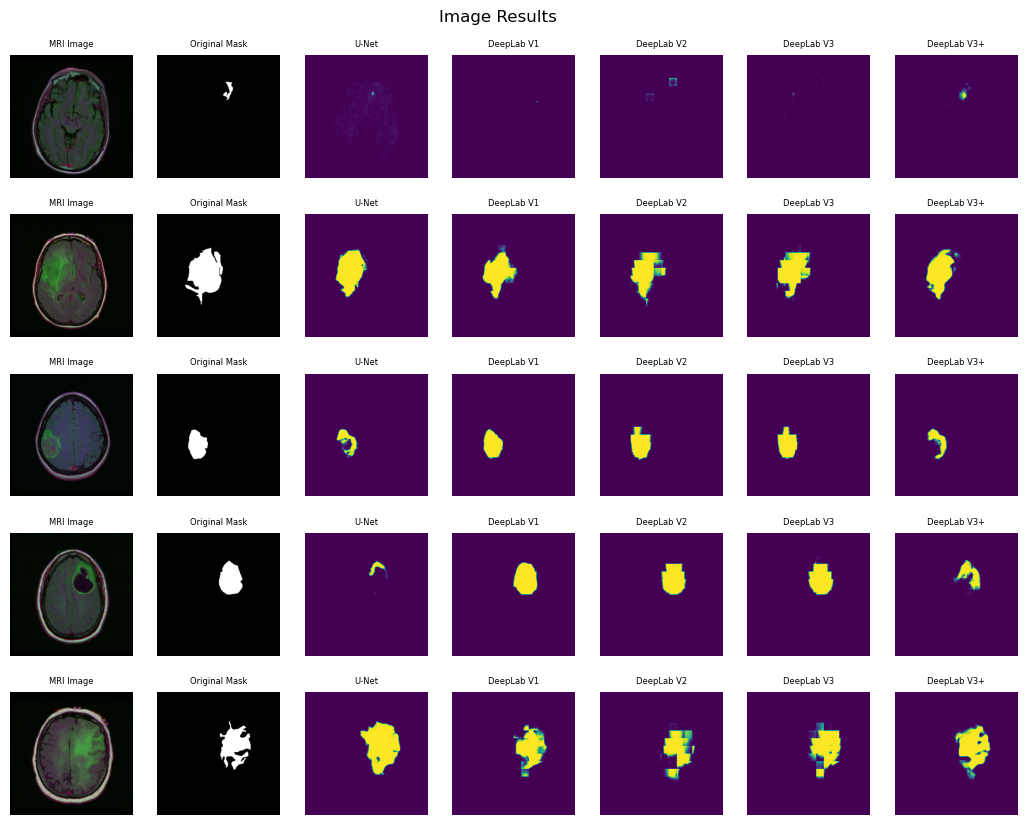

In [37]:
fig, axs = plt.subplots(5, 7, figsize=(13, 10))

for i in range(5):
    # Original MRI Image
    mri_sm = cv2.imread(test_img_samples[i])
    axs[i, 0].imshow(mri_sm)
    axs[i, 0].axis("off")
    axs[i, 0].set_title("MRI Image", fontsize=6)
    
    # Original Mask
    mask_sm = cv2.imread(test_mask_samples[i])
    axs[i, 1].imshow(mask_sm)
    axs[i, 1].axis("off")
    axs[i, 1].set_title("Original Mask", fontsize=6)
    
    for j in range(5):
        axs[i, j+2].imshow(predictions[j][i])
        axs[i, j+2].axis("off")
        axs[i, j+2].set_title(all_title[j], fontsize=6)

# Title
plt.suptitle("Image Results", x=0.5, y=0.92)

# Show
plt.show()